# Impact d'événements disruptifs sur le marché

On considère 5 évènements disruptifs majeurs :

1. Catastrophe naturelle :
Incendies en Californie - 8 novembre 2018 (début)

2. Evenement sectoriel :
Scandale des opioïdes (Purdue Pharma & Big Pharma) - 25 octobre 2017 (premier procès d'État majeur contre les fabricants d’opioïdes)

3. Evenement entreprise :
Apple : Publication résultats Q4 catastrophiques - 2 janvier 2019

4. Evenement mondial :
Invasion de l’Ukraine par la Russie - 24 février 2022 (début officiel à l’aube)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Pour cette section, les seules données requises sont les données Yahoo Finance S&P 500 auxquelles on a ajouté les features.

In [ ]:
df = pd.read_csv("..\data\dataset_with_feature.csv")

On précise le secteur auquel appartient chaque entreprise

In [25]:
import requests

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}

resp = requests.get(url, headers=headers)
resp.raise_for_status()  # lève une erreur si 4xx/5xx

tables = pd.read_html(resp.text, header=0)
sp500 = tables[0]

sp500 = sp500.rename(columns={"Symbol": "Ticker", "GICS Sector": "Sector"})
sp500['Ticker'] = sp500['Ticker'].str.replace('.', '-', regex=False)

df = df.sort_values(by=['Ticker', 'Date'])

df = df.merge(
    sp500[['Ticker', 'Sector']], 
    on='Ticker', 
    how='left'
)


# code repris de description_2

C:\Users\lloyd\AppData\Local\Temp\ipykernel_18892\131376753.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=0)


In [26]:
df['Sector'].unique()

array(['Health Care', 'Information Technology', 'Financials',
       'Consumer Staples', 'Industrials', 'Utilities', 'Materials',
       'Real Estate', 'Consumer Discretionary', 'Energy',
       'Communication Services', nan], dtype=object)

In [27]:
df['Date']  = pd.to_datetime(df['Date'])

I. Incendies en Californie

In [28]:
date_event = pd.to_datetime('2018-11-08')

df_event = df[(df['Date'] >= date_event - pd.Timedelta(days=15)) & (df['Date'] <= date_event + pd.Timedelta(days=15))].copy()

L'entreprise PG&E a été tenu responsable de l'incendie en Californie, on va observer l'impact de cet événement au global, et pour cette entreprise en particulier.

In [29]:
df_pcg = df_event[df_event['Ticker'] == 'PCG'].copy()

1. Returns

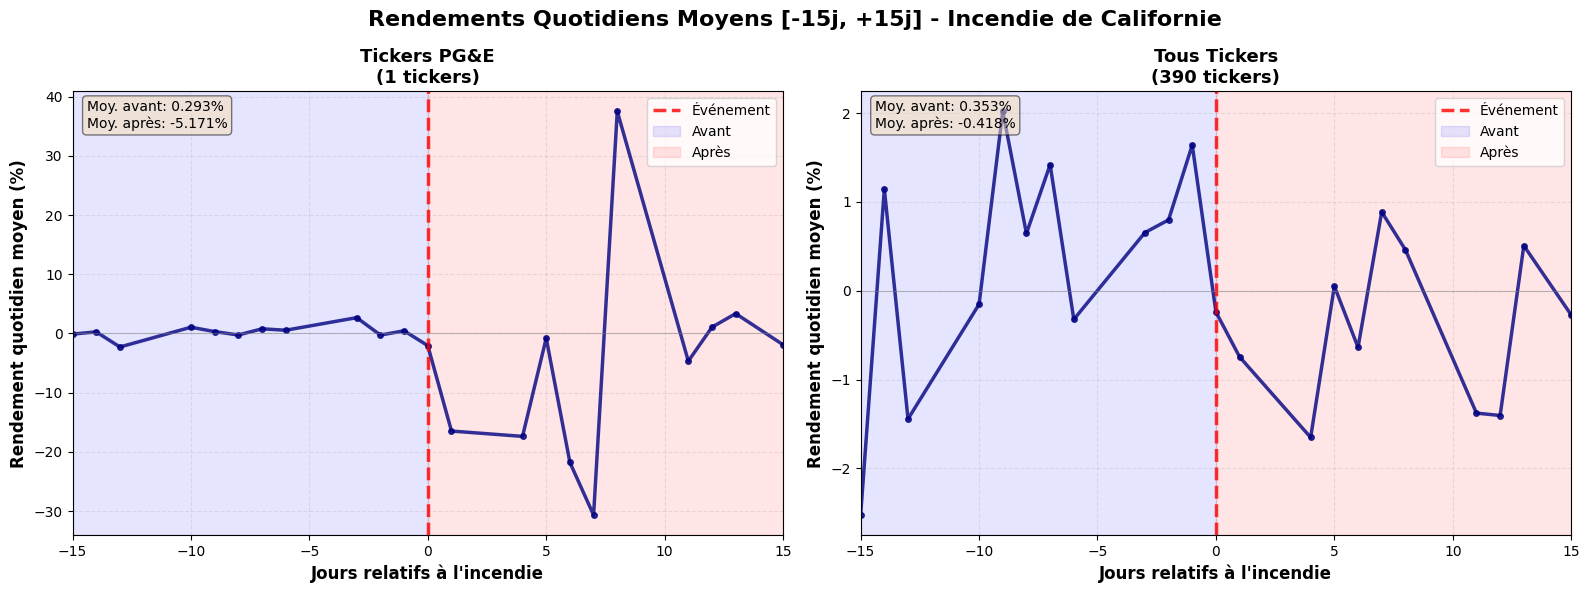

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_pcg, 'Tickers PG&E', axes[0]),
    (df_event, 'Tous Tickers', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_returns = df_subset.groupby('Date')['R1J'].mean() * 100
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_returns.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_returns.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rendement quotidien moyen (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['R1J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['R1J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Titre général
fig.suptitle(f'Rendements Quotidiens Moyens [-15j, +15j] - {'Incendie de Californie'}',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

Le graphique montre que l’incendie de Californie a un impact très marqué sur PG&E, dont les rendements moyens chutent nettement après l’événement, tandis que le reste du marché reste pratiquement inchangé. Cette réaction différenciée s’explique par le fait que PG&E est directement mise en cause dans l’origine de l’incendie, ce qui fait exploser son risque juridique et financier. Les investisseurs anticipent des amendes colossales, des indemnisations massives et même un risque de faillite, ce qui entraîne une réévaluation brutale de l’action et donc une baisse persistante de ses rendements. À l’inverse, les autres entreprises n’ont aucun lien économique avec l’événement, ne subissent aucune exposition directe, on ne mesure donc pas d'impact direct sur leur rendement.

2. Volatilité

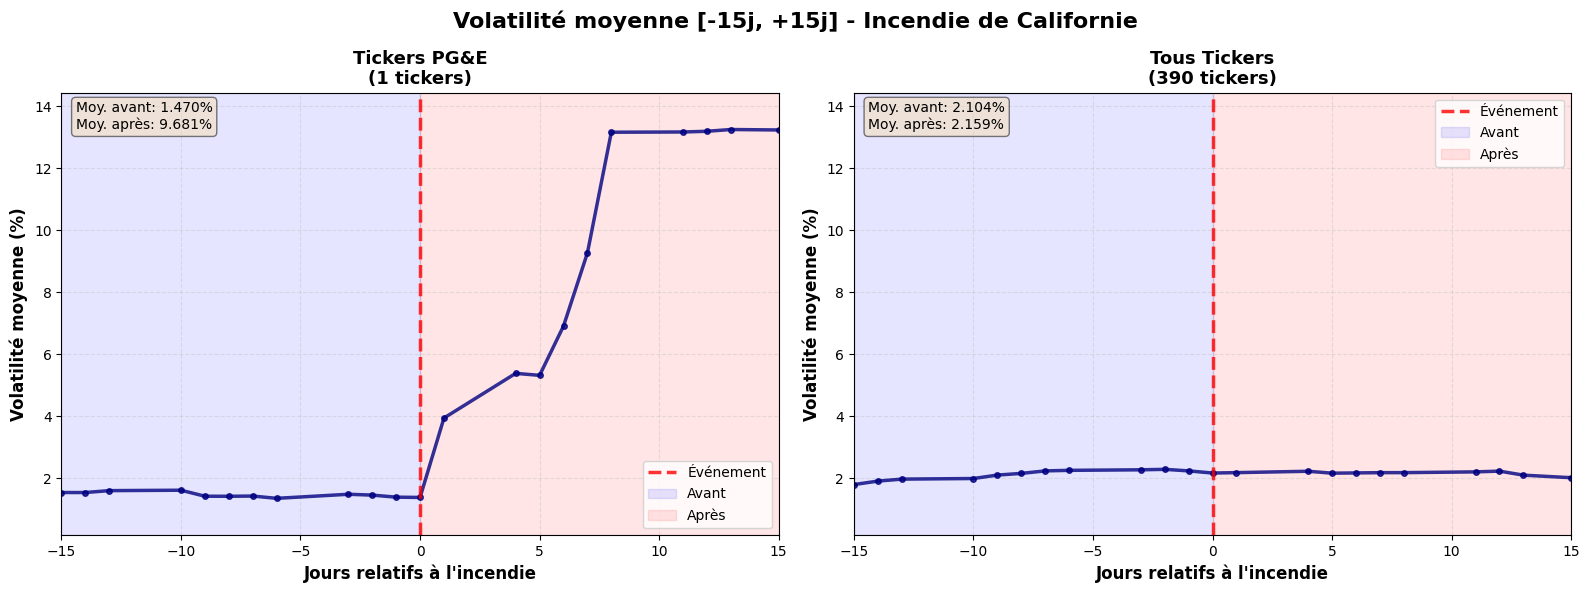

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_pcg, 'Tickers PG&E', axes[0]),
    (df_event, 'Tous Tickers', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volatility = df_subset.groupby('Date')['Volatilite 20J'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volatility.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volatility.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volatility.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatilité moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['Volatilite 20J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['Volatilite 20J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1 

for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volatilité moyenne [-15j, +15j] - Incendie de Californie',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

Le graphique de volatilité montre une explosion très nette de la variabilité des rendements pour PG&E immédiatement après l’incendie, alors que la volatilité des autres entreprises reste globalement stable. Cette hausse extrême de volatilité traduit l’incertitude massive à laquelle l’entreprise fait soudain face : les investisseurs ne savent pas encore si PG&E devra payer des dizaines de milliards de dollars, si elle sera poursuivie au civil, si elle pourra lever suffisamment de capitaux ou même survivre à l’événement, ce qui provoque des fluctuations intenses des anticipations et donc du prix. À l’inverse, les autres entreprises ne subissent aucun changement de risque fondamental, ce qui explique leur volatilité pratiquement inchangée.

3. Volume

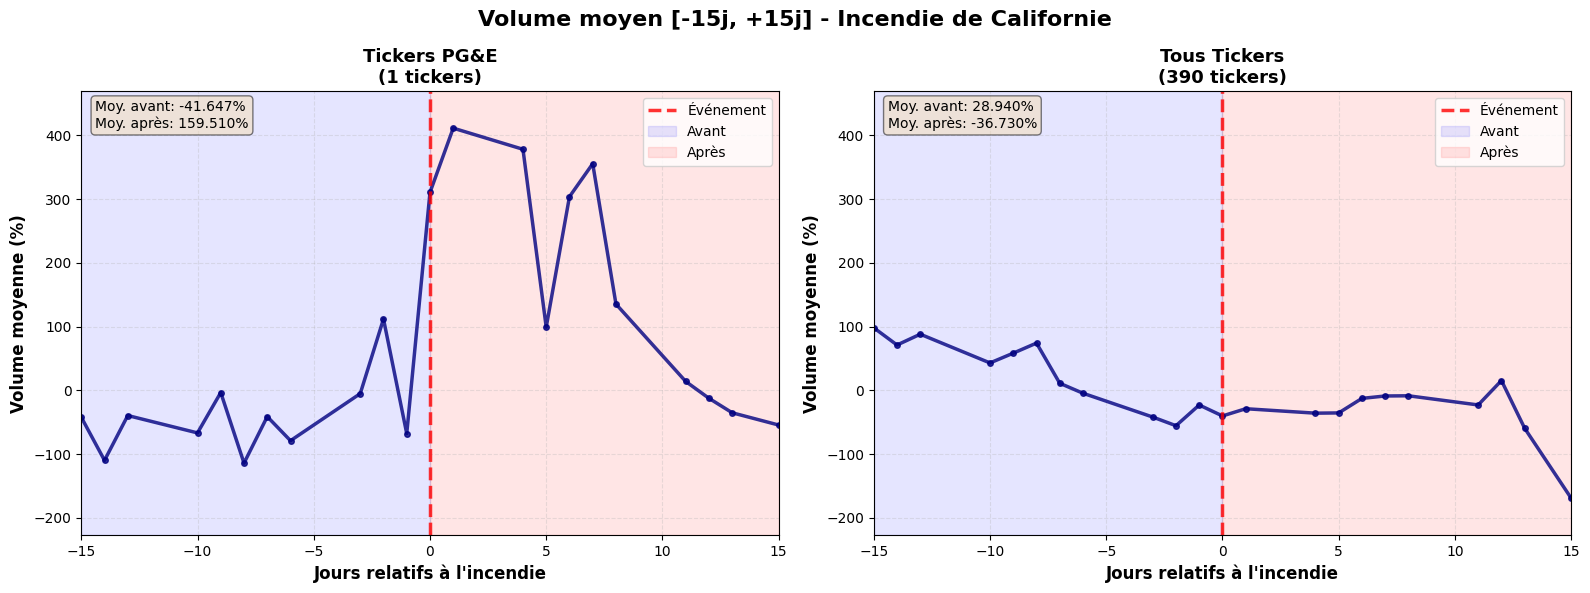

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_pcg, 'Tickers PG&E', axes[0]),
    (df_event, 'Tous Tickers', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volume = df_subset.groupby('Date')['volume_zscore'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volume.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volume.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volume.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0 (retirée car volume ne peut être négative)
    # ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volume moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['volume_zscore'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['volume_zscore'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1 

for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volume moyen [-15j, +15j] - Incendie de Californie',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

Le graphique du volume montre un saut massif des échanges pour PG&E autour de l’incendie, alors que les autres entreprises conservent des volumes proches de leur niveau habituel. Cette explosion du volume s’explique par un phénomène double : d’une part, une vague de ventes d’investisseurs cherchant à se couvrir ou à se débarrasser d’un actif devenu risqué ; d’autre part, l’entrée de traders opportunistes attirés par la volatilité et l’incertitude. Le volume reflète ainsi la réallocation rapide du capital provoquée par le choc d’information, typique d’un événement grave affectant directement une entreprise. Pour les autres entreprises non exposées à l’incendie, le volume n’enregistrent aucune rupture notable.

II. Scandale des opioïdes

In [33]:
date_event = pd.to_datetime('2017-10-25')

df_event = df[(df['Date'] >= date_event - pd.Timedelta(days=15)) & (df['Date'] <= date_event + pd.Timedelta(days=15))].copy()

On va comparer l'impact entre le secteur 'Health Care' et les autres secteurs.

In [34]:
df_hc = df_event[df_event['Sector'] == 'Health Care'].copy()
df_other = df_event[df_event['Sector'] != 'Health Care'].copy()

On s'intéresse cette fois à l'impact sur la volatilité.

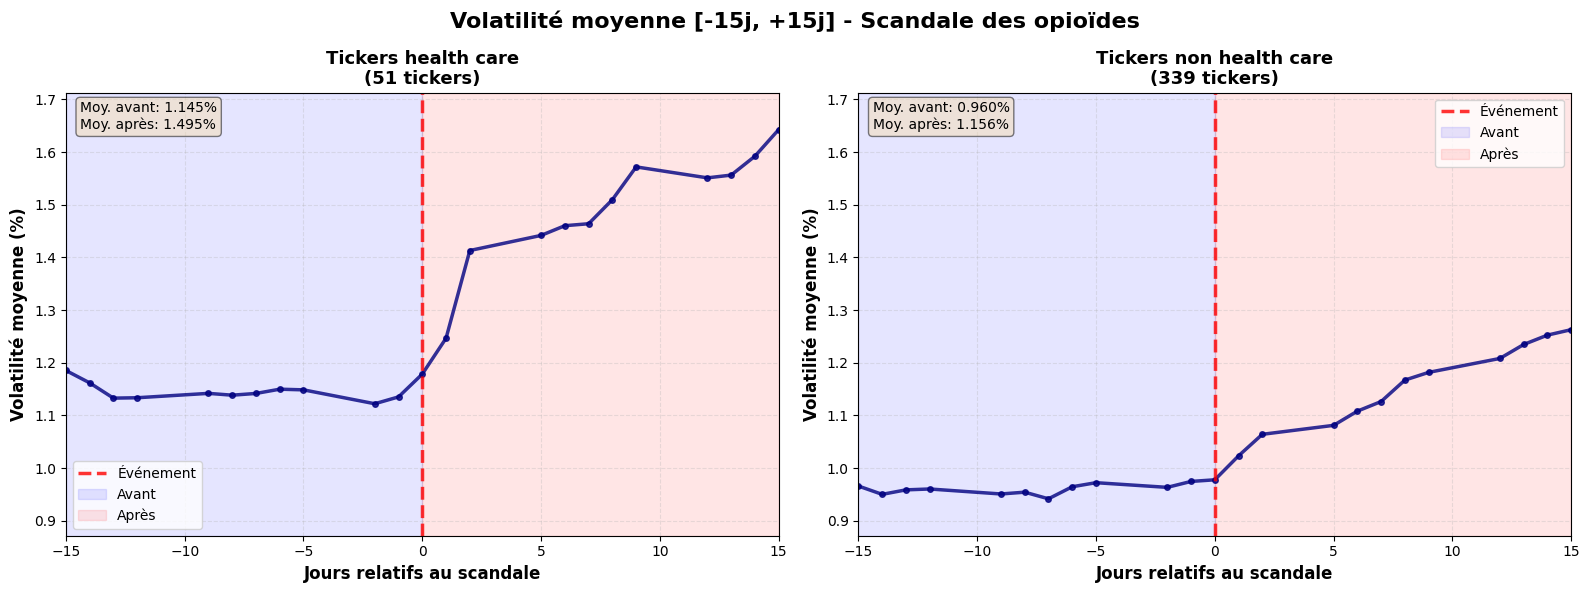

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_hc, 'Tickers health care', axes[0]),
    (df_other, 'Tickers non health care', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volatility = df_subset.groupby('Date')['Volatilite 20J'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volatility.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volatility.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volatility.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs au scandale', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatilité moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['Volatilite 20J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['Volatilite 20J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1 

for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volatilité moyenne [-15j, +15j] - Scandale des opioïdes',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

Le graphique montre que, autour du scandale des opioïdes, la volatilité des entreprises du secteur de la santé (healthcare) augmente sensiblement, tandis que celle des entreprises hors santé reste plus stable. Cette divergence reflète la manière dont l’événement touche de façon asymétrique les acteurs du marché : le scandale entraîne une incertitude juridique, politique et financière importante pour les laboratoires pharmaceutiques et les distributeurs impliqués dans la crise des opioïdes (risques de poursuites massives, amendes fédérales, régulations renforcées et réputation durablement dégradée) ce qui accroît brutalement l’incertitude perçue par les investisseurs et donc la volatilité de leurs actions. À l’inverse, les entreprises non liées à la santé ne sont pas exposées à ces risques spécifiques et ne voient donc pas leur structure de risque évoluer. La hausse de volatilité dans le groupe healthcare traduit ainsi l’impact direct du choc d’information, tandis que la stabilité du groupe non healthcare confirme que l’événement est sectoriel plutôt que systémique.

III. Publication résultats Q4 catastrophiques d'Apple

In [36]:
date_event = pd.to_datetime('2019-01-02')

df_event = df[(df['Date'] >= date_event - pd.Timedelta(days=15)) & (df['Date'] <= date_event + pd.Timedelta(days=15))].copy()

Cette fois on s'intéresse à Apple, au secteur 'Information Technology' (excepté Apple) et aux autres.

In [37]:
df_apl = df_event[df_event['Ticker'] == 'AAPL'].copy()
df_it = df_event[(df_event['Sector'] == 'Information Technology') & (df_event['Ticker'] != 'AAPL')].copy()
df_other = df_event[df_event['Sector'] != 'Information Technology'].copy()

1. Volatilité

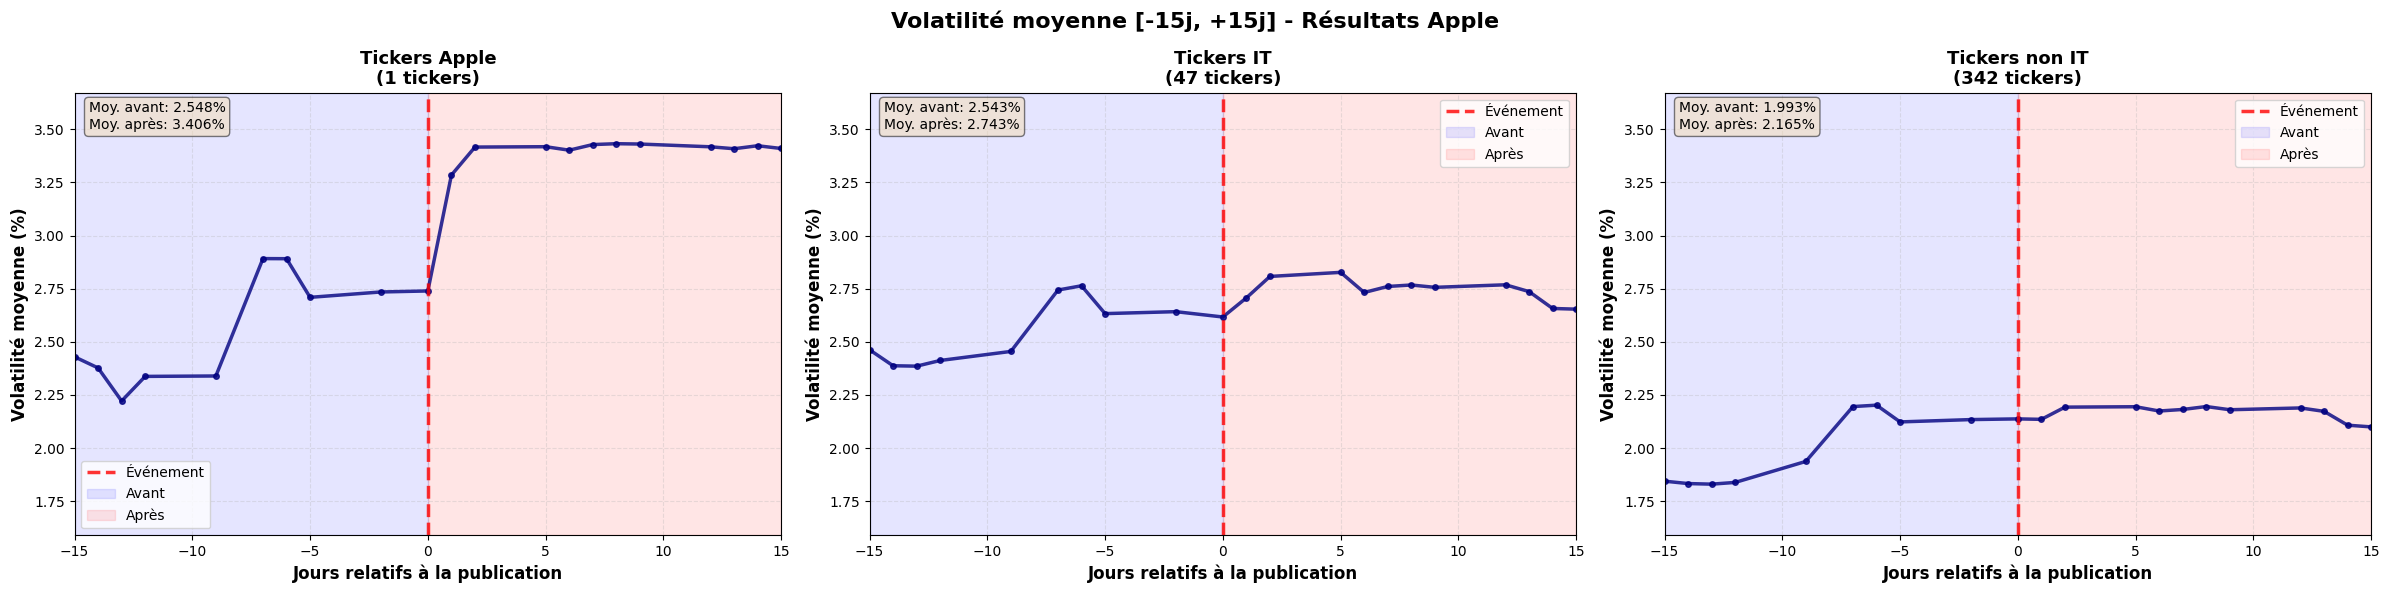

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))


all_volatilities = []
for df_subset in [df_apl, df_it, df_other]:
    daily_avg = df_subset.groupby('Date')['Volatilite 20J'].mean() * 100
    all_volatilities.extend(daily_avg.values)

y_min = min(all_volatilities)
y_max = max(all_volatilities)
margin = (y_max - y_min) * 0.15
y_min -= margin
y_max += margin


for idx, (df_subset, label, ax) in enumerate([
    (df_apl, 'Tickers Apple', axes[0]),
    (df_it, 'Tickers IT', axes[1]),
    (df_other, 'Tickers non IT', axes[2])
]):
    daily_avg_volatility = df_subset.groupby('Date')['Volatilite 20J'].mean() * 100
    dates = daily_avg_volatility.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    ax.plot(days_relative, daily_avg_volatility.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    ax.set_xlabel('Jours relatifs à la publication', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatilité moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    
    ax.set_xlim(-15, 15)
    ax.set_ylim(y_min, y_max) 
    
    mean_before = df_subset[df_subset['Date'] < date_event]['Volatilite 20J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['Volatilite 20J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle(f'Volatilité moyenne [-15j, +15j] - Résultats Apple',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

2. Volume

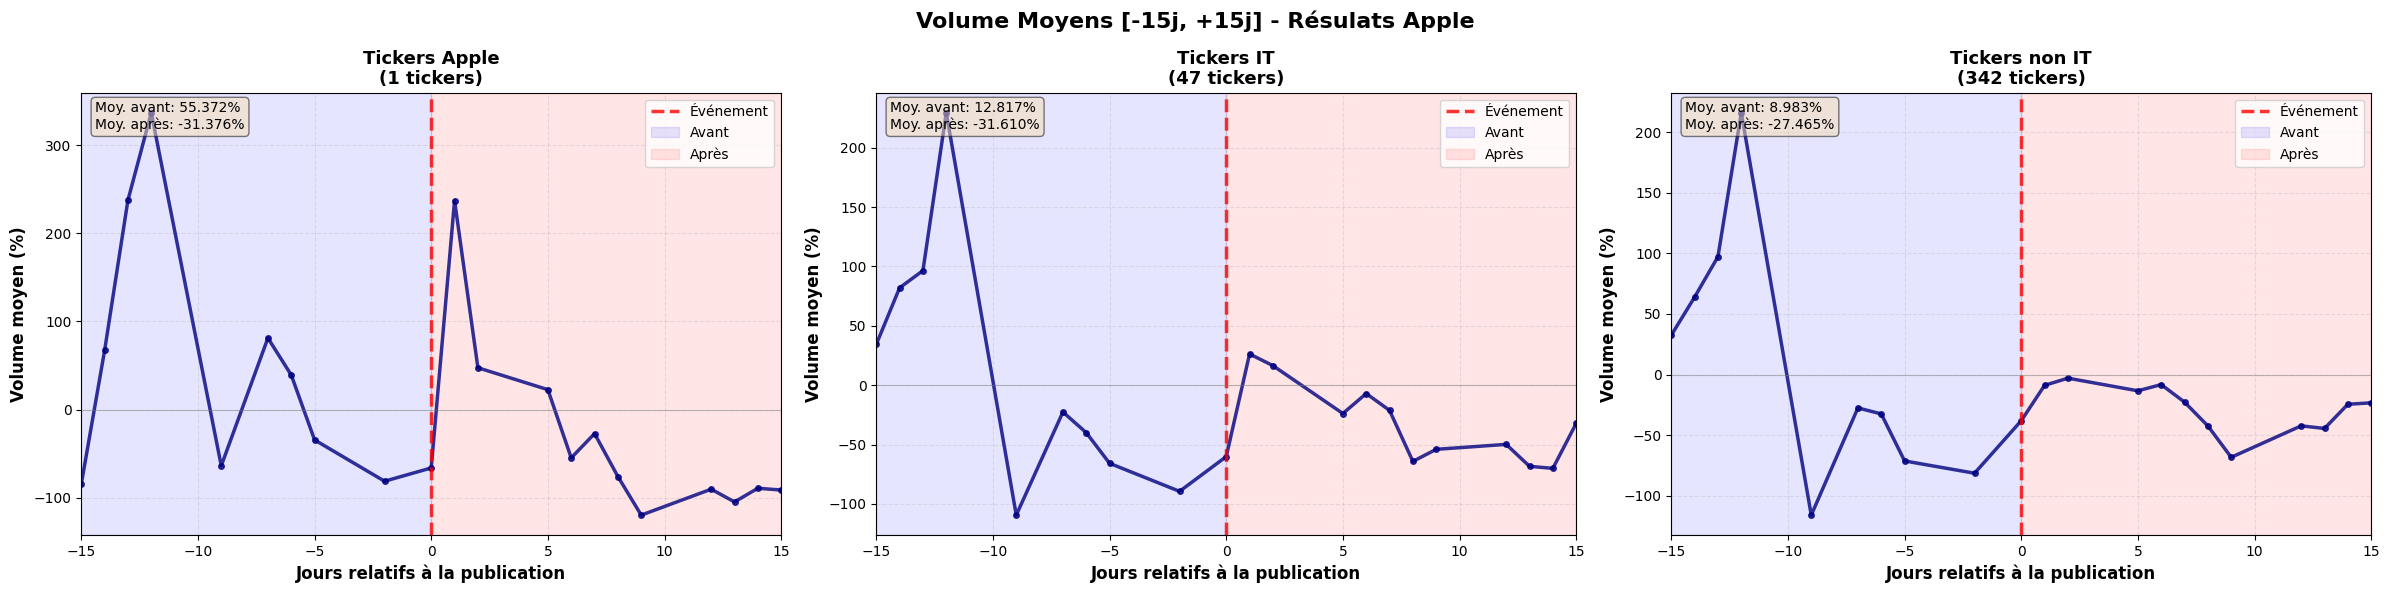

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_apl, 'Tickers Apple', axes[0]),
    (df_it, 'Tickers IT', axes[1]),
    (df_other, 'Tickers non IT', axes[2])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volume = df_subset.groupby('Date')['volume_zscore'].mean() * 100
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volume.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volume.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à la publication', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volume moyen (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['volume_zscore'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['volume_zscore'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Titre général
fig.suptitle(f'Volume Moyens [-15j, +15j] - {'Résulats Apple'}',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

L’ensemble des graphiques montre que l’événement affectant Apple déclenche une réaction de marché forte et spécifique à l’entreprise, alors que les autres acteurs, qu’ils appartiennent au secteur technologique ou non, restent largement insensibles. D'abord, la volatilité d’Apple augmente nettement, révélant une montée de l’incertitude liée au choc d’information, alors que la volatilité des groupes IT et non-IT reste stable, confirmant l’absence de risque systémique. Ensuite, les volumes de transaction explosent pour Apple, signe d’un repositionnement massif des investisseurs (ventes paniques et prises de positions opportunistes) alors que les autres entreprises ne connaissent pas de changement notable dans leur liquidité.

IV Invasion de l’Ukraine par la Russie

Comparons cette fois l'impact de ces deux événements pour tous les secteurs.

In [41]:
date_ukrain = pd.to_datetime('2022-02-24')

df_ukrain = df[(df['Date'] >= date_ukrain - pd.Timedelta(days=15)) & (df['Date'] <= date_ukrain + pd.Timedelta(days=15))].copy()

df_before_ukrain = df_ukrain[df_ukrain['Date'] < date_ukrain]
df_after_ukrain = df_ukrain[df_ukrain['Date'] > date_ukrain]

sectors = df_ukrain['Sector'].unique()
results_ukrain = []

for sector in sectors:

    sector_before = df_before_ukrain[df_before_ukrain['Sector'] == sector]
    sector_after = df_after_ukrain[df_after_ukrain['Sector'] == sector]

    r1j_before = sector_before['R1J'].mean() * 100
    r1j_after = sector_after['R1J'].mean() * 100
    delta_rendement = r1j_after - r1j_before
    
    zscore_before = sector_before['volume_zscore'].mean()
    zscore_after = sector_after['volume_zscore'].mean()
    delta_volume = zscore_after - zscore_before
    
    n_tickers = df_ukrain[df_ukrain['Sector'] == sector]['Ticker'].nunique()
    
    results_ukrain.append({
        'Secteur': sector,
        'N_Tickers': n_tickers,
        'Rendement_Avant': r1j_before,
        'Rendement_Apres': r1j_after,
        'Delta_Rendement': delta_rendement,
        'Volume_Avant': zscore_before,
        'Volume_Apres': zscore_after,
        'Delta_Volume': delta_volume,
    })

On s'intéresse aux rendements et au volume.

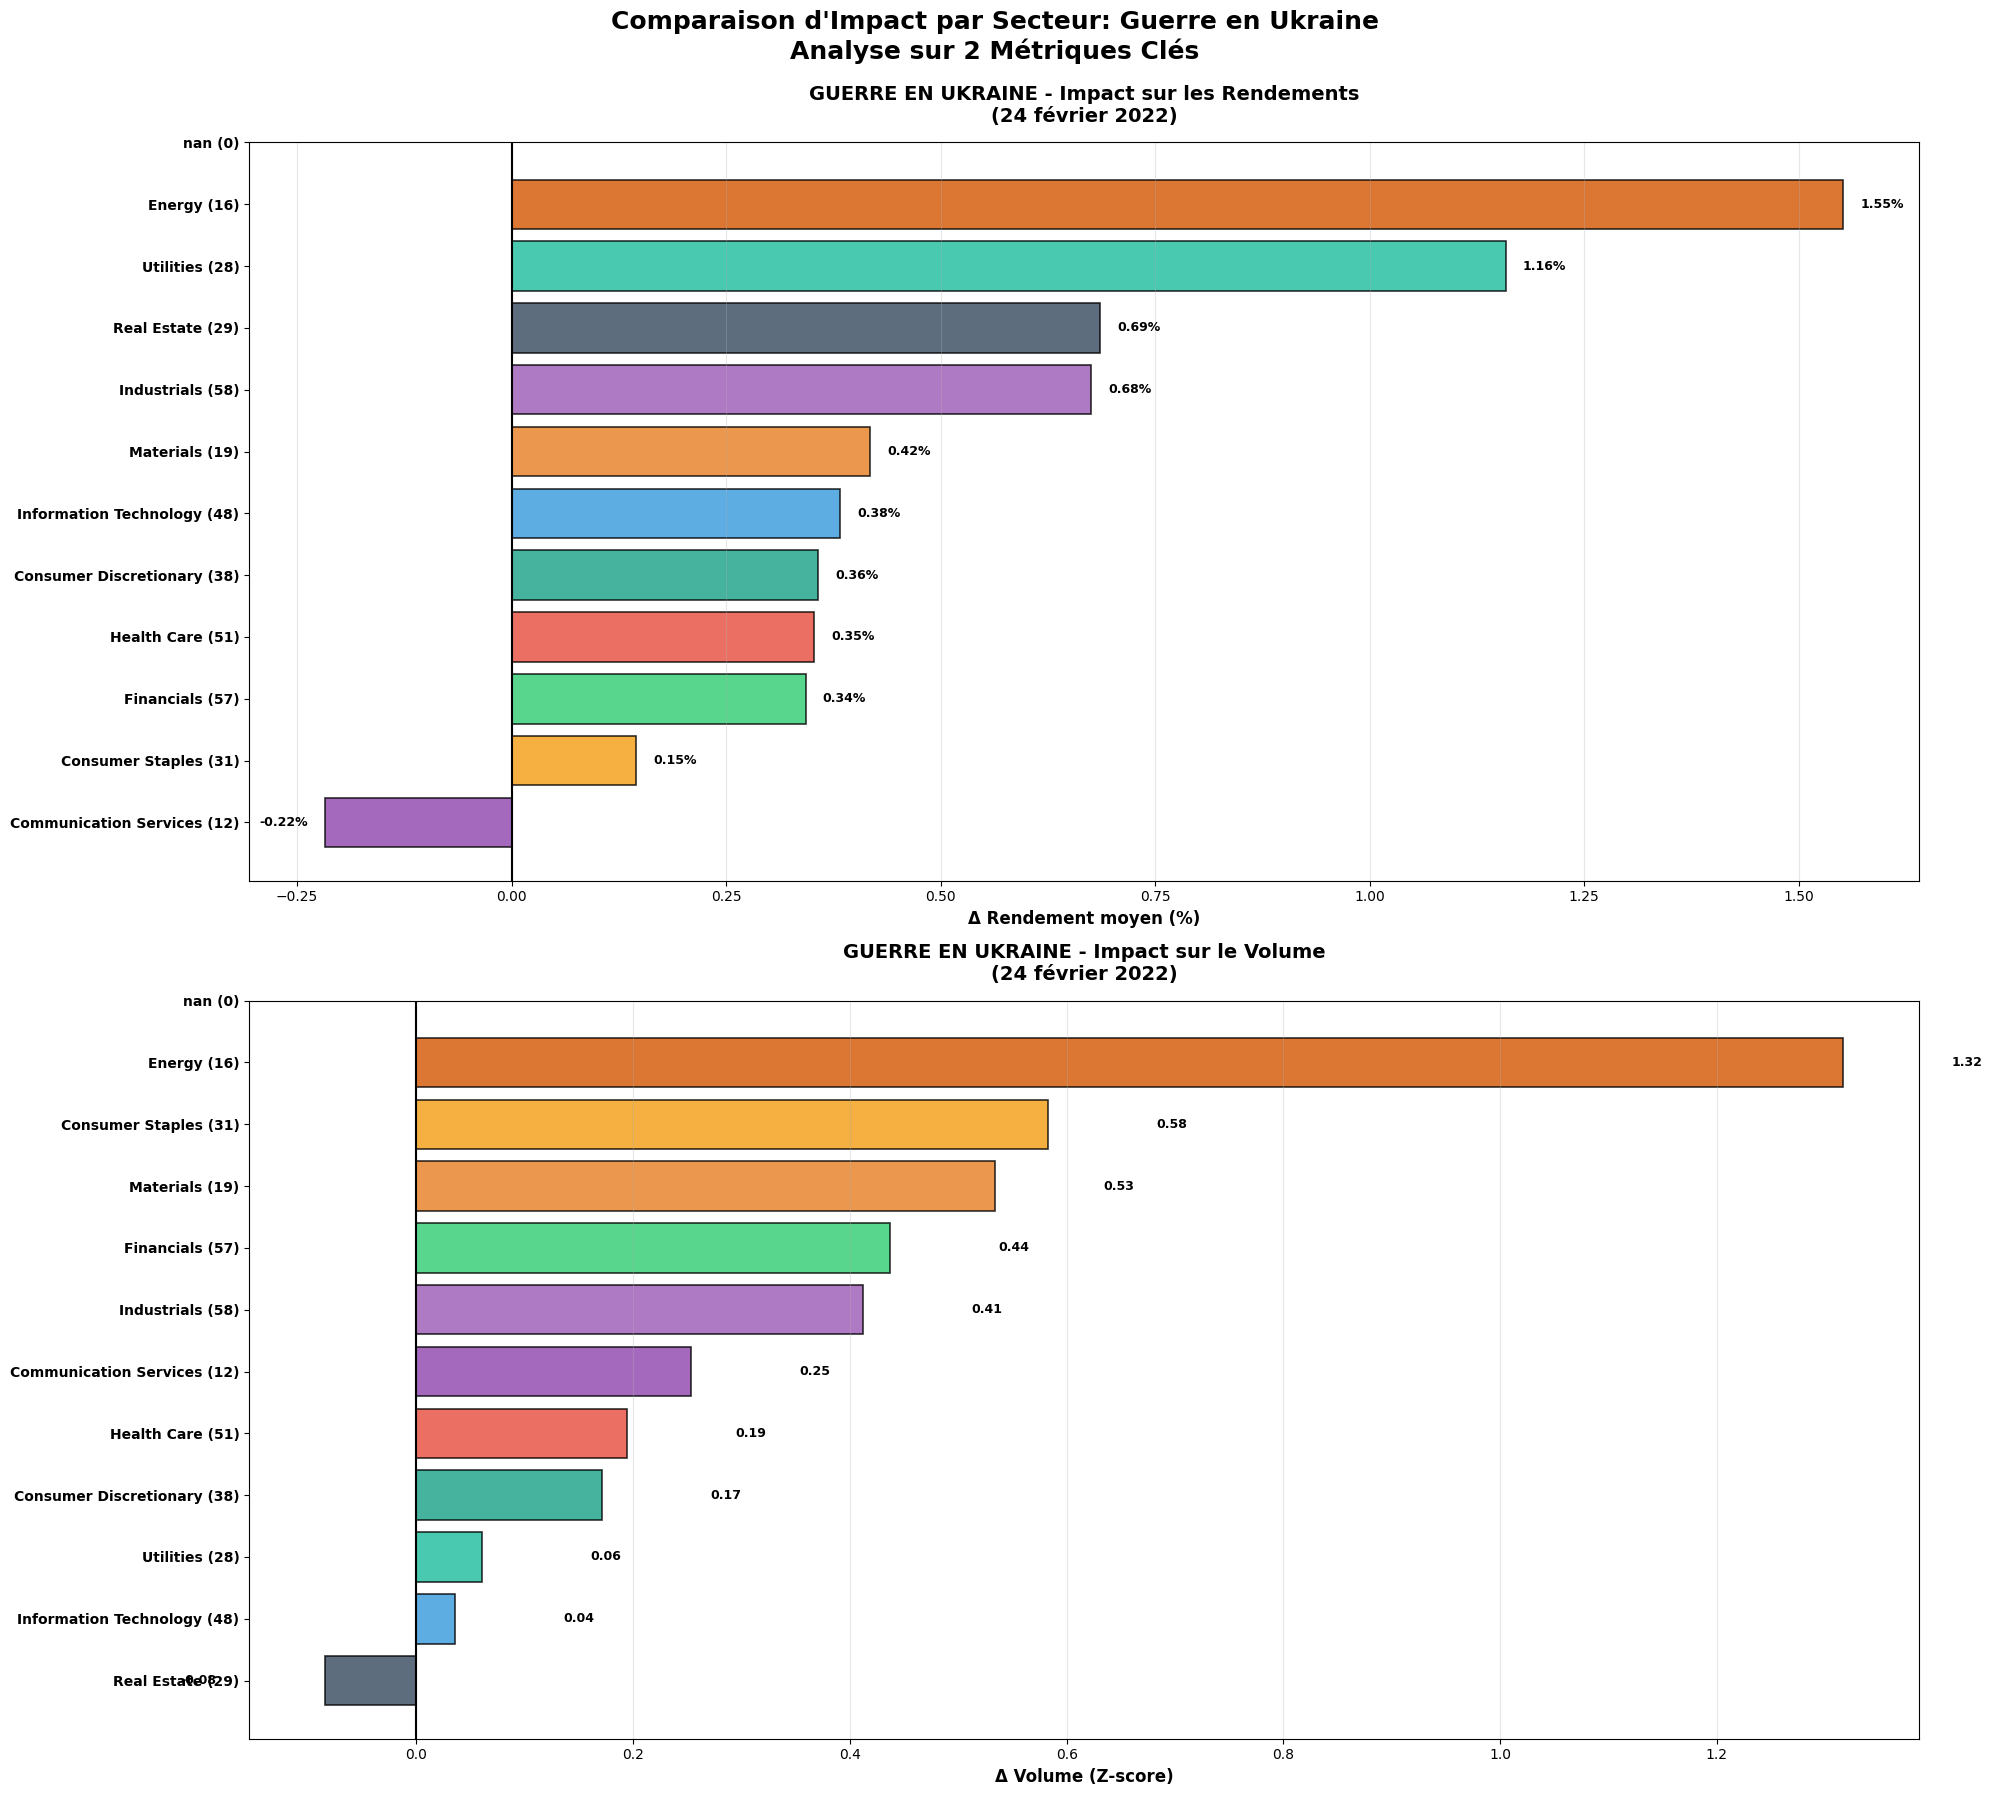

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 18))
plt.subplots_adjust(hspace=0.35)

sector_colors = {
    'Health Care': '#e74c3c',
    'Information Technology': '#3498db',
    'Financials': '#2ecc71',
    'Consumer Staples': '#f39c12',
    'Industrials': '#9b59b6',
    'Utilities': '#1abc9c',
    'Materials': '#e67e22',
    'Real Estate': '#34495e',
    'Consumer Discretionary': '#16a085',
    'Energy': '#d35400',
    'Communication Services': '#8e44ad'
}

# Rendements
df_uk_r = pd.DataFrame(results_ukrain).sort_values('Delta_Rendement', ascending=True)
y_pos = np.arange(len(df_uk_r))
colors = [sector_colors.get(s, '#95a5a6') for s in df_uk_r['Secteur']]

bars = ax1.barh(y_pos, df_uk_r['Delta_Rendement'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(df_uk_r.iterrows()):
    value = row['Delta_Rendement']
    ax1.text(value + (0.02 if value > 0 else -0.02), i, f"{value:.2f}%", 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=9, fontweight='bold')
    
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"{s} ({n})" for s, n in 
                    zip(df_uk_r['Secteur'], df_uk_r['N_Tickers'])],
                    fontsize=10, fontweight='bold')
ax1.set_xlabel('Δ Rendement moyen (%)', fontsize=12, fontweight='bold')
ax1.set_title('GUERRE EN UKRAINE - Impact sur les Rendements\n(24 février 2022)',
                fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.axvline(x=0, color='black', linewidth=1.5)


# Volume
df_uk_vol = pd.DataFrame(results_ukrain).sort_values('Delta_Volume', ascending=True)
y_pos = np.arange(len(df_uk_vol))
colors = [sector_colors.get(s, '#95a5a6') for s in df_uk_vol['Secteur']]

bars = ax2.barh(y_pos, df_uk_vol['Delta_Volume'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(df_uk_vol.iterrows()):
    value = row['Delta_Volume']
    ax2.text(value + (0.1 if value > 0 else -0.1), i, f"{value:.2f}", 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=9, fontweight='bold')

ax2.set_yticks(y_pos)
ax2.set_yticklabels([f"{s} ({n})" for s, n in 
                    zip(df_uk_vol['Secteur'], df_uk_vol['N_Tickers'])],
                    fontsize=10, fontweight='bold')
ax2.set_xlabel('Δ Volume (Z-score)', fontsize=12, fontweight='bold')
ax2.set_title('GUERRE EN UKRAINE - Impact sur le Volume\n(24 février 2022)',
                fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(x=0, color='black', linewidth=1.5)


fig.suptitle('Comparaison d\'Impact par Secteur: Guerre en Ukraine\nAnalyse sur 2 Métriques Clés',
            fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

Le graphique montre clairement que le déclenchement de la guerre en Ukraine a provoqué un choc sectoriel asymétrique, avec des impacts très différents selon les industries : les secteurs directement exposés aux matières premières, à l’énergie ou aux chaînes d’approvisionnement internationales (notamment l’Énergie, les Matériaux et l’Industrie) affichent une hausse ou une moindre baisse des rendements, reflétant une anticipation de tensions sur l’offre, de hausses de prix et d’opportunités pour certains producteurs, tandis que des secteurs plus sensibles au risque géopolitique ou dépendants de la stabilité macroéconomique (comme la Technologie, la Consommation discrétionnaire ou la Finance) enregistrent des rendements plus fortement négatifs, en raison des craintes de ralentissement économique, de hausse des risques de marché et d’incertitude globale. Du côté des volumes, la guerre déclenche une envolée particulièrement marquée dans les secteurs les plus exposés aux répercussions immédiates du conflit (notamment l’Énergie et les Matériaux) traduisant une réallocation rapide du capital vers les « gagnants » anticipés de la crise, tandis que des secteurs moins concernés présentent des mouvements plus modérés. La guerre agit comme un choc géopolitique majeur, provoquant une réaction violente mais différenciée selon l’exposition sectorielle aux matières premières, au risque global et aux perspectives macroéconomiques.